# Tuning learning rate
Now, I know the learning rate is the key to our model's convergence. I have tried 6 different learning rates: 10^(0, -1, -2, -3, -4, -5). The results are shown below.

## Functions

In [66]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from test_mask_ratio import get_dataloader
import pandas as pd

def eval(model, spe_arr):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(24)
        spe = torch.from_numpy(spe_arr)
        return model(spe.unsqueeze(0).float())
    
def unpatchify(mask, pred, model):
    pred_un = model.unpatchify(pred)
    pred_un_arr = pred_un.squeeze(0).numpy()

    mask_arr = mask.squeeze(0).numpy()
    mask_un_arr = np.array([])
    for i in mask_arr:
        mask_un_arr = np.concatenate((mask_un_arr, np.repeat(i, 16)))
    mask_un_arr = mask_un_arr.astype(int)

    return pred_un_arr, mask_un_arr

def plot_spectrum(spe_arr, pred_un_arr, mask_un_arr, ymax=30):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    scale = .001
    channel = np.arange(1, len(spe_arr)+1)
    for ax in axes:
        if ax == axes[0]: # normal view
            # I don't use ax.bar because it has issue on drawing at the exact positions
            # when the drawing density is too high due to the small figure size
            # this issue disappears when the figure size is large enough or zoom in
            ax.vlines(channel, ymin=0, ymax=mask_un_arr*(spe_arr.max()*scale), color='gray', alpha=0.3, label='masked')
            ax.plot(channel, spe_arr*scale, alpha=.8, label='raw')
            ax.plot(channel, pred_un_arr*scale, alpha=.6, label='pred')
            ax.set_xlim(-1, 2050)
            ax.set_ylim(0, spe_arr.max()*scale)
            ax.set_ylabel('Counts (K)')
        else: # zoom in
            ax.vlines(channel, ymin=0, ymax=mask_un_arr*ymax, color='gray', alpha=0.3, label='masked')
            ax.plot(channel, spe_arr, alpha=.8, label='raw')
            ax.plot(channel, pred_un_arr, alpha=.6, label='pred')
            
            ax.set_ylim(0, ymax)
            ax.set_ylabel('Counts')
            ax.set_xlim(-1, 2050)

        ax.set_xlabel('Channel')
        ax.legend()
    plt.show()

In [4]:
lr_df = pd.read_csv('results/test_lr_20231207.csv')
lr_df

,lr,min_val_loss
0,1.00000,1.746515e+07
1,0.10000,9.288235e+06
2,0.01000,2.482055e+06
3,0.00100,1.454281e+07
4,0.00010,1.741753e+07
5,0.00001,1.747705e+07


Text(0, 0.5, 'Minimum validation loss in 100 epochs')

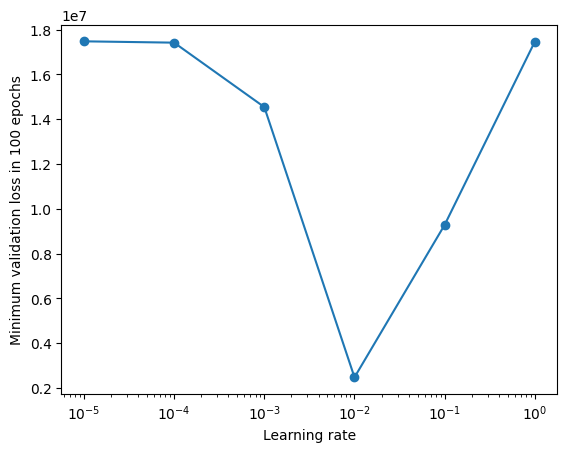

In [9]:
plt.plot(lr_df.lr, lr_df.min_val_loss, 'o-')
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Minimum validation loss in 100 epochs')

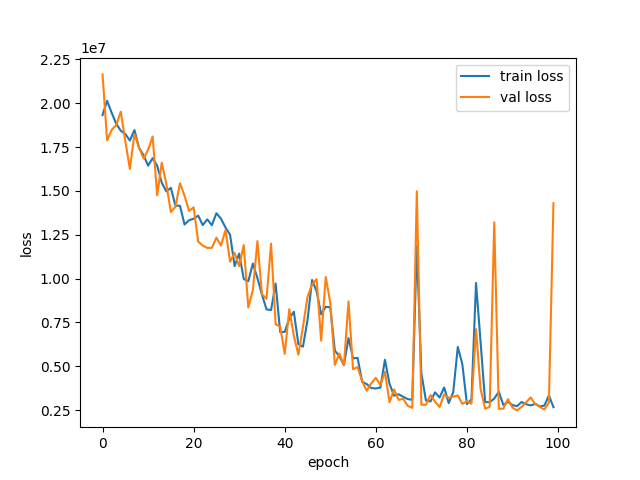

In [10]:
from IPython.display import Image
Image(filename='results/loss_0.01_20231207.png')

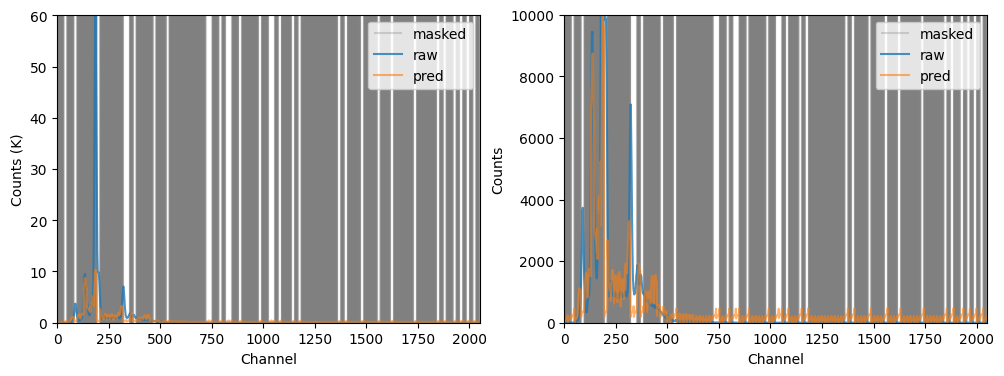

In [58]:
from models_mae import mae_vit_base_patch16
model = mae_vit_base_patch16()
model.load_state_dict(torch.load('models/mae_vit_base_patch16_0.01_20231207.pth'))

dataloader = get_dataloader(batch_size=64)
spe_arr = dataloader['train'].dataset[0]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr, ymax=1e4)

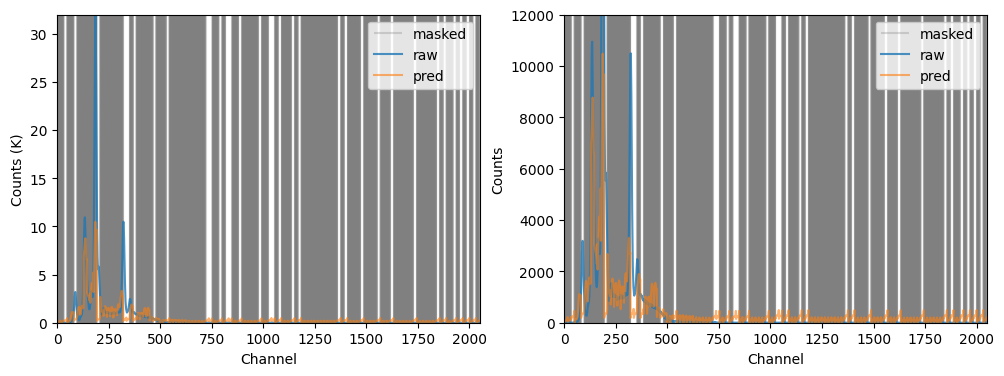

In [59]:
# inference on the validation set
spe_arr = dataloader['val'].dataset[60]

loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr, ymax=1.2e4)

Among the learning rates, only 10^(-1, -2, -3) show the converging trend during 100 ephochs. The 0.01 learning rate gives the bset loss in the validation set. The slightly better performance on the masked parts still exists. The loss between the training set and the validation set is not significant, so the model is not overfitting. It's expcted because the model is still far from good.

Now, I know the model, the loss and the training process work. I can start to train the model on the whole dataset and tune the hyperparameters. Or I should tune the pilot model to the reasonable loss and then train the whole dataset?